In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
colnames = ["Existing Account", "Duration in month", "Credit history", "Purpose", "Credit amount", "Savings account/bonds", 
            "Present employment", "Installment rate", "Personal status and gender",
            "Other debtors", "Present residence", "Property", "Age", "installment plans",
            "Housing", "Number of existing credits", "Job", "Number of people being liable", "Telephone",
            "foreign worker", "Classification"]

df = pd.read_csv('german.data', sep = ' ', names = colnames, header = None)

In [3]:
df.head()

,Existing Account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment,Installment rate,Personal status and gender,Other debtors,...,Property,Age,installment plans,Housing,Number of existing credits,Job,Number of people being liable,Telephone,foreign worker,Classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Existing Account                 1000 non-null object
Duration in month                1000 non-null int64
Credit history                   1000 non-null object
Purpose                          1000 non-null object
Credit amount                    1000 non-null int64
Savings account/bonds            1000 non-null object
Present employment               1000 non-null object
Installment rate                 1000 non-null int64
Personal status and gender       1000 non-null object
Other debtors                    1000 non-null object
Present residence                1000 non-null int64
Property                         1000 non-null object
Age                              1000 non-null int64
installment plans                1000 non-null object
Housing                          1000 non-null object
Number of existing credits       1000 non-null int64
Job                              100

There are no missing values in the data.

Let's see how the numeric features are spread

In [5]:
df.describe()

,Duration in month,Credit amount,Installment rate,Present residence,Age,Number of existing credits,Number of people being liable,Classification
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In the 'Credit amount' column, the mean value (3271.29) slightly deviates from the median value (2319.5)

This is probably due to the fact that the there is a big difference between the 75% percentile and maximum value.

### Convert target variable to binary values

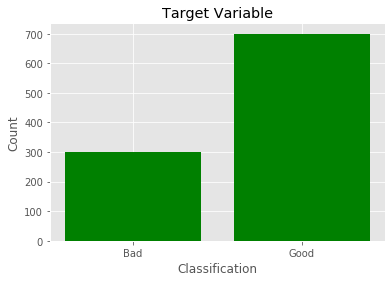

1    700
0    300
Name: Classification, dtype: int64

In [6]:
df.Classification.replace([1,2], [1,0], inplace = True)

plt.style.use('ggplot')

x = ['Bad', 'Good']
values = [df.Classification.value_counts()[0], df.Classification.value_counts()[1]]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, values, color='green')
plt.xlabel("Classification")
plt.ylabel("Count")
plt.title("Target Variable")

plt.xticks(x_pos, x)

plt.show()

df.Classification.value_counts()

### Exploring Continuous Variables

Before moving towards preprocessing of categorical variables, I am going to plot the correlation matrix so that only continuous variables are captured since analyzing categorical variables with correlation matrix makes no sense. 

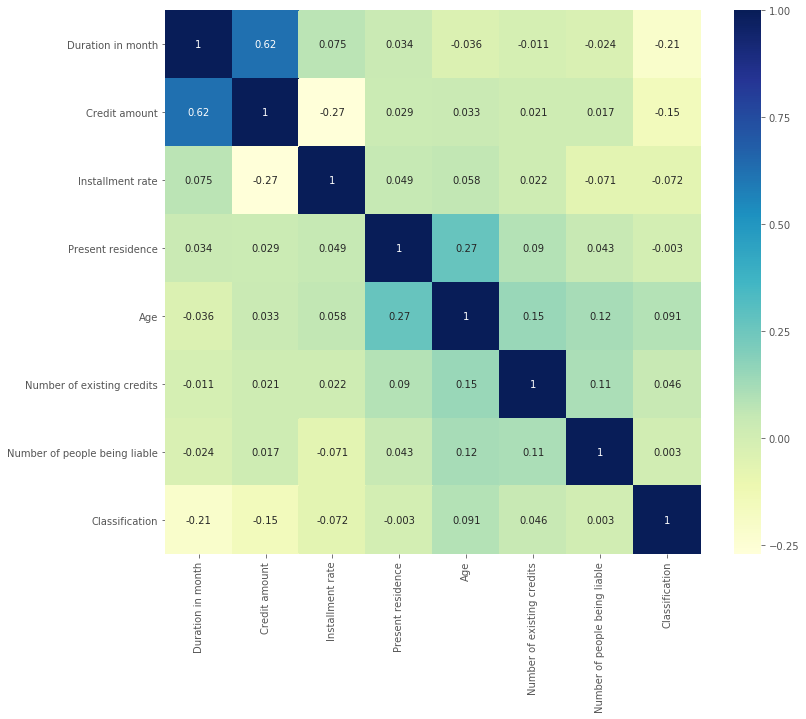

In [7]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot = True, cmap = "YlGnBu")
plt.show()

Let's draw some insights from the above matrix

- There is a strong positive correlation between 'Credit amount' and 'Duration in months'
- Alternatively, there seems to be a slightly negative correlation between 'Credit amount' and 'Installment rate'
- The age slightly correlates positively with presence residence
- There was no correlation found between age and target variable, let's analyze it further.

In [8]:
df_good = df[df["Classification"] == 1]
df_bad = df[df["Classification"] == 0]

Now, I am going to plot values of age for each class separately

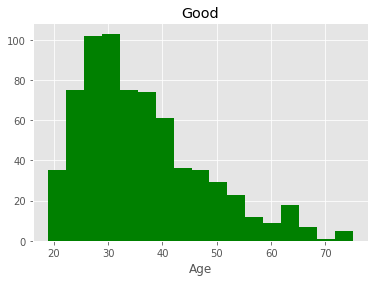

In [9]:
# Age of "Good" class of customers

plt.hist(df_good["Age"], bins = 'auto', color = 'green')
plt.title("Good")
plt.xlabel("Age")

plt.show()

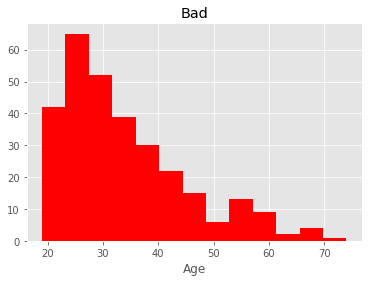

In [10]:
# Age of "Bad" class of customers

plt.hist(df_bad["Age"], bins = 'auto', color = 'red')
plt.title("Bad")
plt.xlabel("Age")

plt.show()

There doesn't seem to be any variation in age that would affect the target variable.

Now, I am going to perform binning on the Age variable into 4 intervals and analyze how each age group has any affect on the different variables

In [11]:
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

Relationship between Age and Credit Amount

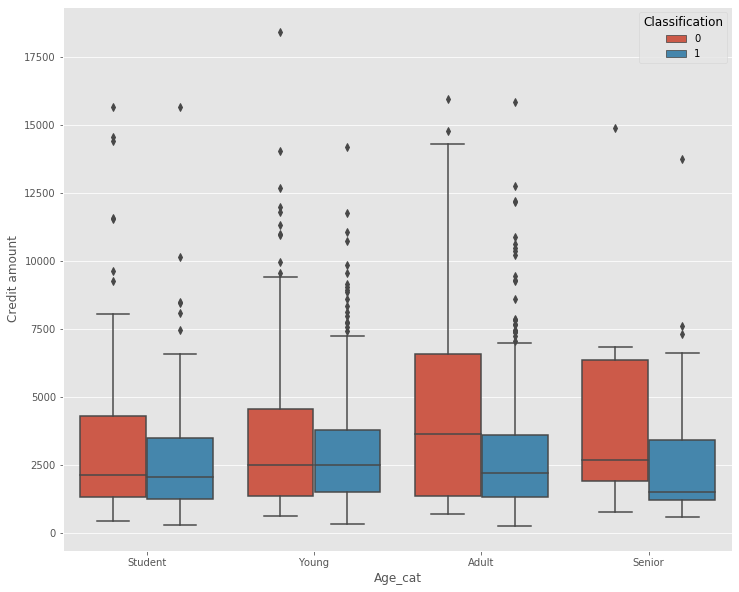

In [12]:
plt.figure(figsize=(12,10))
sns.boxplot(y = 'Credit amount', x = 'Age_cat', data = df, hue = 'Classification')
plt.show()

#### Relationship between Age and Month Duration

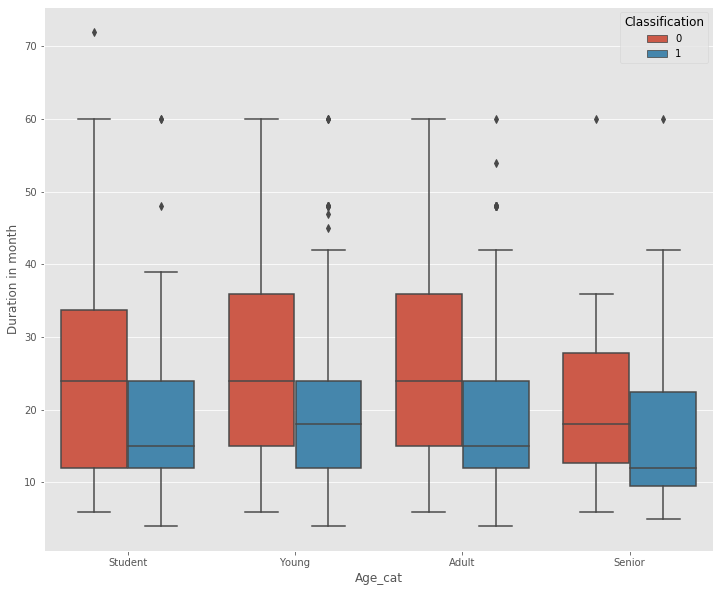

In [13]:
plt.figure(figsize=(12,10))
sns.boxplot(y = 'Duration in month', x = 'Age_cat', data = df, hue = 'Classification')
plt.show()

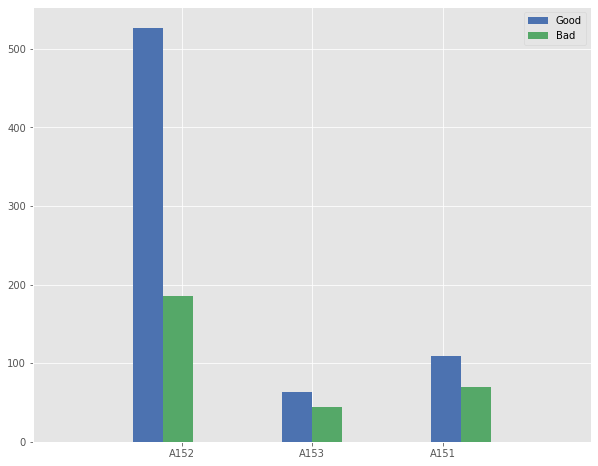

In [14]:
plt.figure(figsize=(10,8))

bins = np.linspace(-1, 3, 8)

plt.style.use('seaborn-deep')

plt.hist([df_good['Housing'], df_bad['Housing']], bins, label=['Good', 'Bad'])
plt.legend(loc='upper right')
plt.show()

This shows that people who own a house are more likely to be considered "good" classifiers

#### Relationship between Credit Amount and Gender

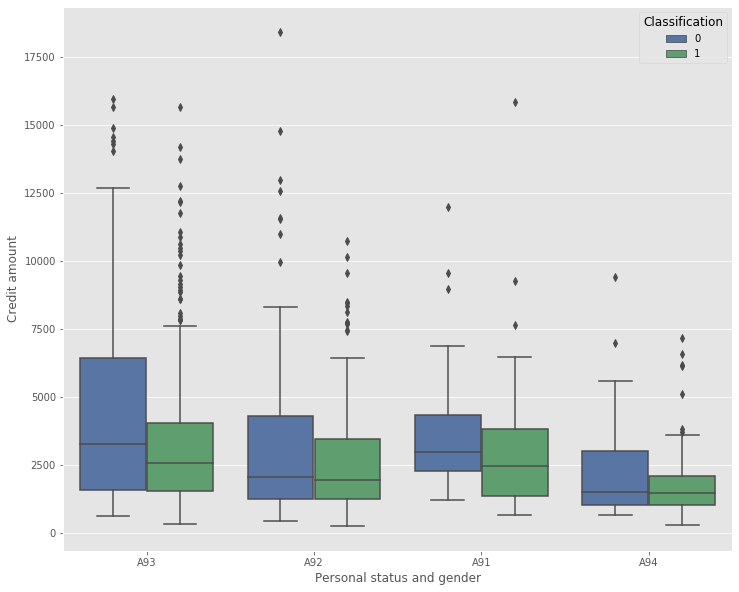

In [15]:
plt.figure(figsize=(12,10))
sns.boxplot(y = 'Credit amount', x = 'Personal status and gender', data = df, hue = 'Classification')
plt.show()

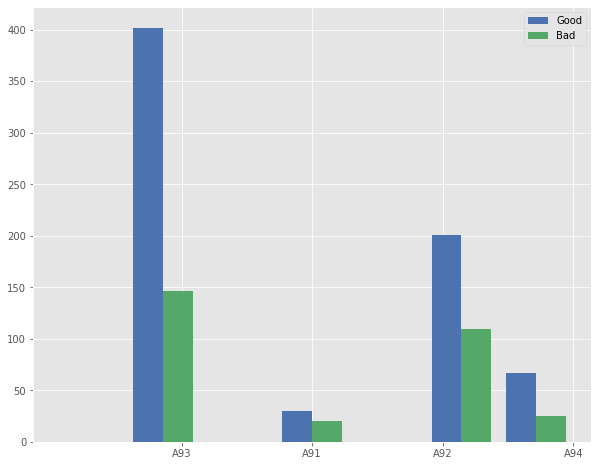

In [16]:
plt.figure(figsize=(10,8))

bins = np.linspace(-1, 3, 8)

plt.style.use('seaborn-deep')

plt.hist([df_good['Personal status and gender'], df_bad['Personal status and gender']], bins, label=['Good', 'Bad'])
plt.legend(loc='upper right')
plt.show()

Single males are more likely to be considered "good" classifiers.

In [17]:
df = df.drop('Age_cat', axis = 1)

Now, let's see how many credits were granted for each purpose.

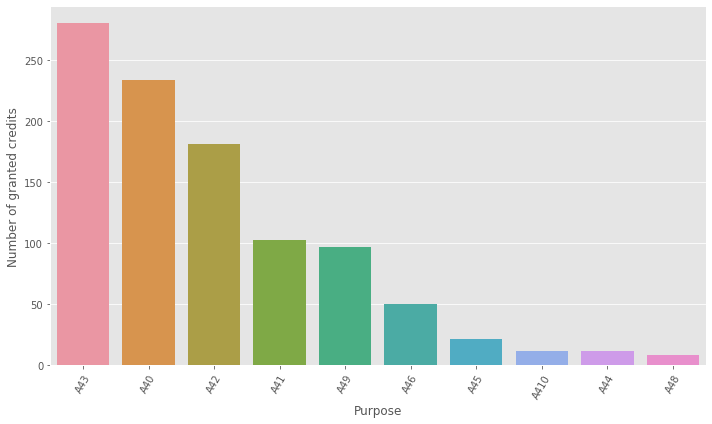

In [18]:
data = df
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize = (10,6))
bar = sns.barplot(x = "Purpose", y = "Count", data = n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation = 60)
plt.ylabel("Number of granted credits")
plt.tight_layout()

Looks like radio/television (A43) were granted most of the credit for, followed by cars (A40)

But how do we know what the largest amount of credits were granted for? Let's analyze that using boxplot.

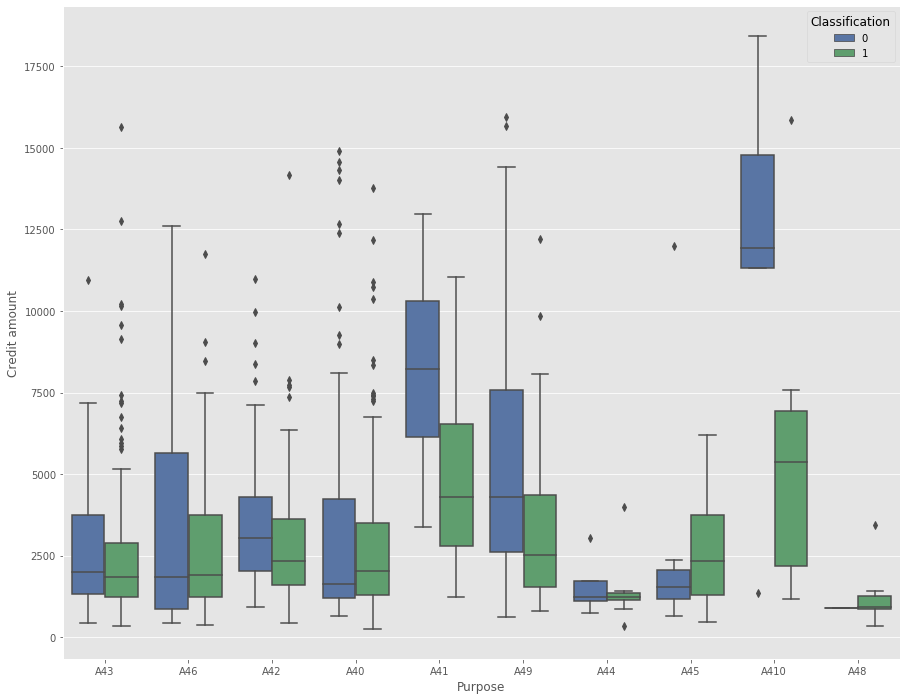

In [19]:
plt.figure(figsize=(15,12))
sns.boxplot(y = 'Credit amount', x = 'Purpose', data = df, hue = 'Classification')
plt.show()

Most of the credit was granted for purposes that are not stated, but interestingly the people who were granted greater amount of credit where likely the ones to default.

### Hypothesis testing of continuous variables

Let's test our hypotheses against the insights derived from the correlation matrix above

#### 1. Relationship between 'Credit amount' and 'Duration in months'

Using Pearson's Correlation test to test dependence

In [20]:
stat, p = pearsonr(df['Credit amount'], df['Duration in month'])

print('stat = %.3f, p = %.3f' % (stat, p))

if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat = 0.625, p = 0.000
Probably dependent


#### 2. Relationship between 'Credit amount' and 'Installment rate'

In [21]:
stat, p = pearsonr(df['Credit amount'], df['Installment rate'])

print('stat = %.3f, p = %.3f' % (stat, p))

if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat = -0.271, p = 0.000
Probably dependent


#### 3. Relationship between Age and Credit amount

In [22]:
stat, p = pearsonr(df['Credit amount'], df['Age'])

print('stat = %.3f, p = %.3f' % (stat, p))

if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat = 0.033, p = 0.301
Probably independent


### Preprocessing of Categorial Variables

There are 2 ways to convert categorical variables to numeric values

- Label Encoding: it will assign 'n' sequence of numbers to 'n' classes in the column
- One Hot Encoding: it will add a new column for each 'n' class and assign binary values to them

The problem with Label Encoding is that since there are different numbers assigned to a column, the model may misinterpret the data to be in some kind of order. Using One Hot Encoding will resolve this issue, but then again, it may introduce the 'curse of dimensionality' by increasing the number of columns significantly.

Keeping in mind the trade-off in this case, I will use Label Encoding on only specific columns in which the "order" would really make sense, for example, the column 'Present employment' in which a greater number would indicate a greater criticality level. For other columns, I'll use the One Hot Encoding method.

Moreover, there are two features 'Telephone' and 'foreign worker' that have binary classification so let's encode them using Label Encoder as well.

In [23]:
# Columns to encode using Label Encoder
cols = ['Credit history', 'Present employment', 'Job', 'foreign worker', 'Housing', 'Purpose', 'Telephone']

dict = defaultdict(LabelEncoder)

# Encode the categories
encode = df[cols].apply( lambda x: dict[x.name].fit_transform(x) )


# Replace categorical values with equivalent numeric values
for x in range( len(cols) ):
    df[cols[x]] = encode[cols[x]]

In [24]:
df.head()

,Existing Account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment,Installment rate,Personal status and gender,Other debtors,...,Property,Age,installment plans,Housing,Number of existing credits,Job,Number of people being liable,Telephone,foreign worker,Classification
0,A11,6,4,4,1169,A65,4,4,A93,A101,...,A121,67,A143,1,2,2,1,1,0,1
1,A12,48,2,4,5951,A61,2,2,A92,A101,...,A121,22,A143,1,1,2,1,0,0,0
2,A14,12,4,7,2096,A61,3,2,A93,A101,...,A121,49,A143,1,1,1,2,0,0,1
3,A11,42,2,3,7882,A61,3,2,A93,A103,...,A122,45,A143,2,1,2,2,0,0,1
4,A11,24,3,0,4870,A61,2,3,A93,A101,...,A124,53,A143,2,2,2,2,0,0,0


Looks great. Before applying One Hot Encoding to other columns, there are a few columns that I think do not have any influence on the target variable such as the 'Telephone' column.

Therefore, I will perform chi-squared test of independence to test my hypothesis.

In [25]:
# Contingency table
table = [df['Telephone'].replace( [0, 1], [1, 2] ), df['Classification'].replace( [0, 1], [1, 2] )]

stat, p, dof, expected = chi2_contingency(table)

Here,
- stat: the test statistic
- p: the p-value of the test
- dof: degree of freedom
- expected: the expected values of contingency table

In [26]:
# Interpreting p-value

# Set significance value to 5%
alpha = 0.05

# Print the p-value
print(p)

if p <= alpha:
    print("Dependent, reject null hypothesis")
else:
    print("Independent, fail to reject null hypothesis")

1.0
Independent, fail to reject null hypothesis


Therefore, we can accept our hypothesis that Telephone has no correlation with target variable, and we can drop the column.

In [27]:
df = df.drop('Telephone', axis = 1)
df.head()

,Existing Account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment,Installment rate,Personal status and gender,Other debtors,Present residence,Property,Age,installment plans,Housing,Number of existing credits,Job,Number of people being liable,foreign worker,Classification
0,A11,6,4,4,1169,A65,4,4,A93,A101,4,A121,67,A143,1,2,2,1,0,1
1,A12,48,2,4,5951,A61,2,2,A92,A101,2,A121,22,A143,1,1,2,1,0,0
2,A14,12,4,7,2096,A61,3,2,A93,A101,3,A121,49,A143,1,1,1,2,0,1
3,A11,42,2,3,7882,A61,3,2,A93,A103,4,A122,45,A143,2,1,2,2,0,1
4,A11,24,3,0,4870,A61,2,3,A93,A101,4,A124,53,A143,2,2,2,2,0,0


Let's use chi-square test to see if there exists any relation between the 'Purpose' and the target variable

In [28]:
# Contingency table
table = [df['Purpose'], df['Classification'].replace( [0, 1], [1, 2] )]

stat, p, dof, expected = chi2_contingency(table)

alpha = 0.05

# Print the p-value
print(p)

if p <= alpha:
    print("Dependent, reject null hypothesis")
else:
    print("Independent, fail to reject null hypothesis")

0.0005405952910271777
Dependent, reject null hypothesis


As the results suggest, the purpose for the credit has some significance with respect to classification.

Next, we perform One Hot Encoding on the remaining categorical features.

In [29]:
catvars = ['Existing Account', 'Savings account/bonds', 'Personal status and gender',
           'Other debtors', 'Property', 'installment plans']

for cat in catvars:
    
    one_hot = pd.get_dummies( df[cat] )
    
    df = df.drop(cat, axis = 1)
    
    df = df.join(one_hot)
    
    df = df.drop(df.iloc[:, -1:], axis=1)

In [30]:
df.head()

,Duration in month,Credit history,Purpose,Credit amount,Present employment,Installment rate,Present residence,Age,Housing,Number of existing credits,...,A91,A92,A93,A101,A102,A121,A122,A123,A141,A142
0,6,4,4,1169,4,4,4,67,1,2,...,0,0,1,1,0,1,0,0,0,0
1,48,2,4,5951,2,2,2,22,1,1,...,0,1,0,1,0,1,0,0,0,0
2,12,4,7,2096,3,2,3,49,1,1,...,0,0,1,1,0,1,0,0,0,0
3,42,2,3,7882,3,2,4,45,2,1,...,0,0,1,0,0,0,1,0,0,0
4,24,3,0,4870,2,3,4,53,2,2,...,0,0,1,1,0,0,0,0,0,0


There are 30 features and 1 target variable in the dataset now. Let's see if we can merge or reduce some columns

### Feature Selection

In [31]:
# Inserting the target variable at the end of the data

temp = df['Classification']
df = df.drop('Classification', axis = 1)
df['Classification'] = temp

X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

There are many approaches through which we can select features. I am going to use the Variance Threshold approach that drops columns having variance lower than a given proportion.

Let's say we only keep columns that have 80% variance

In [32]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

X = sel.fit_transform(X)

In [33]:
X.shape

(1000, 19)

Now we have 19 features, that means 11 of the features were dropped from the data

### Standard Scaling of features

I am going to standardize the features by using StandardScaler since the standard scaling works better with classification problems.

In [34]:
scaler = StandardScaler()

In [35]:
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [36]:
X = scaler.transform(X)

### Removing the dataset bias

As it was observed earlier, there are 700 samples where the customer is classified as "good" whereas only 300 samples where the customer is classified as "bad"

This means there when the model may produce biased results due to the unequal distribution of classes within the dataset.

To overcome this, there is an approach called SMOTE (Synthetic Minority Oversampling).
For each minority class observation, SMOTE calculates the k nearest neighbors. Depending upon the amount of oversampling needed, one or more of the k-nearest neighbors are selected to create the synthetic examples

In [37]:
sm = SMOTE()

In [38]:
X_sm, y_sm = sm.fit_sample(X, Y)

In [39]:
y_sm.value_counts()

1    700
0    700
Name: Classification, dtype: int64

Perfect, now the dataset is equally balanced.

### Preparing the Model

Since the data is label, this is a supervised learning problem.

There are a number of models that can be used for classification for instance Logistic Regression, KNN clustering, SVM, naive bayes, decision tree etc.

For this dataset, I am going to train two models, KNN and SVM and then compare their results.

In [46]:
# Splitting the dataset into 80 percent training set and 20 percent test set

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.20)

#### K-Nearest Neighbor

In [47]:
classifier = KNeighborsClassifier(n_neighbors = 2)

classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [48]:
y_pred = classifier.predict(X_test)

Let's evaluate our model

In [49]:
accuracy_score(y_test, y_pred)

0.7607142857142857

Accuracy of model: 75%

In [50]:
confusion_matrix(y_test, y_pred)

array([[141,   6],
       [ 61,  72]], dtype=int64)

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81       147
           1       0.92      0.54      0.68       133

    accuracy                           0.76       280
   macro avg       0.81      0.75      0.75       280
weighted avg       0.80      0.76      0.75       280



The 'F1-score' is pretty good which shows the precision of the module regardless of the sample distribution.

Now I am going to apply K-fold cross validation and observe if there is any change in the accuray.

In [52]:
classifier = KNeighborsClassifier(n_neighbors = 2)

# let K = 10
cv_scores = cross_val_score(classifier, X_sm, y_sm, cv = 10)

print(cv_scores)
print('Average accuray:{}'.format(np.mean(cv_scores)))

[0.74285714 0.72142857 0.77857143 0.8        0.76428571 0.82857143
 0.77857143 0.85       0.8        0.77142857]
Average accuray:0.7835714285714286


The average accuracy of the model now yields 78% and hence it did improve from before.

Now, let's train the other model and compare the results of K-nearest neighbor

#### Support Vector Machine

In [72]:
classifier = svm.SVC()

classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [73]:
y_pred = classifier.predict(X_test)

Let's evaluate our model

In [74]:
accuracy_score(y_test, y_pred)

0.7821428571428571

Accuracy of model: 78%

Nice, it improved from before. But let's see what the f1-score has to say.

In [75]:
confusion_matrix(y_test, y_pred)

array([[111,  28],
       [ 33, 108]], dtype=int64)

In [76]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       139
           1       0.79      0.77      0.78       141

    accuracy                           0.78       280
   macro avg       0.78      0.78      0.78       280
weighted avg       0.78      0.78      0.78       280



The 'F1-score' is consistent with the accuracy of the model. Therefore, we can conclue that SVM performs better than KNN in this case.

Again, I will apply K-fold cross validation to observe any change in accuray.

In [53]:
classifier = svm.SVC()

cv_scores = cross_val_score(classifier, X_sm, y_sm, cv = 10)

print(cv_scores)
print('Average accuray:{}'.format(np.mean(cv_scores)))

[0.77142857 0.77142857 0.71428571 0.80714286 0.77142857 0.88571429
 0.81428571 0.87142857 0.85714286 0.81428571]
Average accuray:0.8078571428571427


As observed, the model reaches 80% accuray!